In [92]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# !pip install pybaseball
import pybaseball as pyb

In [93]:
data = pd.read_csv('AnalyticsQuestionnaireHitData.csv')
data.head()

,Unnamed: 0,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,HomeTeamId,AwayTeamId,PitchCall,PitchType,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
0,1,1,1,1,L,R,115,119,called_strike,CH,...,-7.634186,1.087663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,1,1,L,R,115,119,ball,KC,...,-9.791415,3.901629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,1,1,L,R,115,119,field_out,SL,...,-5.721138,2.533320,82.429787,30.821812,204.93396,10.787098,2263.124756,104.179558,295.970184,0.030403
3,4,4,2,1,L,L,115,119,ball,SI,...,-5.594223,-0.382425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,2,1,L,L,115,119,swinging_strike,KC,...,-9.407112,2.861959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
data.columns

Index(['Unnamed: 0', 'PitchId', 'BatterId', 'PitcherId', 'PitcherHand',
       'BatterSide', 'HomeTeamId', 'AwayTeamId', 'PitchCall', 'PitchType',
       'ReleaseSpeed', 'PlateX', 'TrajectoryLocationY', 'PlateZ',
       'StrikeZoneTop', 'StrikeZoneBottom', 'Balls', 'Strikes',
       'VerticalBreak', 'InducedVerticalBreak', 'HorzBreak',
       'VertApproachAngle', 'HorzApproachAngle', 'LaunchSpeed', 'LaunchAngle',
       'LaunchSpinAxis', 'LaunchDirection', 'LaunchSpinRate',
       'LandingPositionX', 'LandingPositionY', 'LandingPositionZ'],
      dtype='object')

In [95]:
# remove columns that are unnecesary. Since this data is all from the same game, the home and away ids will be
# constant for the whole dataframe
data.drop(columns = ['Unnamed: 0','HomeTeamId','AwayTeamId'],inplace = True)

In [96]:
# change InducedVerticalBreak and HorzBreak to inches instead of feet
data.InducedVerticalBreak  = data.InducedVerticalBreak*12
data.HorzBreak  = data.HorzBreak*12

# Change Plate X and Z to inches as well 
data.PlateX  = data.PlateX*12
data.PlateZ  = data.PlateZ*12

In [97]:
data.PitchCall.unique()

array(['called_strike', 'ball', 'field_out', 'swinging_strike', 'single',
       'pickoff_attempt_1b', 'walk', 'foul', 'blocked_ball', 'strikeout',
       'double', 'foul_bunt', 'stolen_base_3b', 'foul_tip',
       'grounded_into_double_play', 'home_run', 'force_out',
       'stolen_base_2b', 'wild_pitch'], dtype=object)

In [98]:
data[data.PitchCall == 'stolen_base_2b']

,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,TrajectoryLocationY,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
255,256,5,6,R,L,stolen_base_2b,CU,80.450233,-5.64341,1.416667,...,-9.383094,-1.334879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# remove any pickoff_attempts because they dont give any valuable information for this analysis
# also plays that result in a stolen base do not have information about if the pitch was a ball or strike
data = data[~data.PitchCall.isin(['pickoff_attempt_1b','stolen_base_2b','stolen_base_3b'])]
data = data.reset_index()

In [100]:
# round some variables
data.ReleaseSpeed = round(data.ReleaseSpeed,1)
data.LaunchSpeed = round(data.LaunchSpeed,2)
data.LaunchAngle = round(data.LaunchAngle,2)

data.HorzBreak = round(data.HorzBreak,2)
data.InducedVerticalBreak = round(data.InducedVerticalBreak,2)

In [101]:
# fill launch speed and launch angle variables with 0 and 'None' respectively
data.LaunchSpeed = data.LaunchSpeed.fillna(0)
data.LaunchAngle = data.LaunchAngle.fillna(0)

In [102]:
data.LaunchSpeed.describe()

count    342.000000
mean      27.472047
std       39.200215
min        0.000000
25%        0.000000
50%        0.000000
75%       71.195000
max      108.270000
Name: LaunchSpeed, dtype: float64

In [103]:
data[data.LaunchSpeed>98]

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,VertApproachAngle,HorzApproachAngle,LaunchSpeed,LaunchAngle,LaunchSpinAxis,LaunchDirection,LaunchSpinRate,LandingPositionX,LandingPositionY,LandingPositionZ
5,5,6,2,1,L,L,single,SI,90.9,8.830505,...,-6.026230,0.089518,104.83,5.19,298.274048,33.187984,3698.538086,63.701733,89.854118,-0.002012
37,38,39,9,1,L,R,double,KC,78.3,-3.441171,...,-8.896836,2.181962,106.03,15.41,95.409523,-30.851000,7708.296875,-155.963638,205.806427,0.008609
66,70,71,14,2,R,R,single,CH,84.8,3.795422,...,-7.014757,-2.936115,102.25,2.95,270.231201,6.944455,664.811951,13.978411,85.844765,0.007282
70,74,75,15,2,R,L,double,CH,87.0,-6.360604,...,-6.222175,-1.903892,104.29,8.24,228.509171,11.528565,1502.839355,48.536957,197.780045,0.000990
156,162,163,2,1,L,L,single,SI,92.0,1.526592,...,-6.573693,0.810912,102.15,11.85,143.365173,5.639507,342.933014,17.708044,224.467789,0.012932
162,168,169,5,1,L,L,foul,SI,93.1,11.769326,...,-6.295873,-0.200350,99.43,-28.62,180.000000,66.939331,4442.365723,4.186556,2.766424,-0.004226
176,182,183,6,2,R,L,home_run,FC,90.4,4.641479,...,-5.960848,-4.346654,100.19,36.35,194.406784,27.789267,3244.253906,247.518646,330.531555,0.019564
197,203,204,11,1,L,L,field_out,SI,92.6,8.445071,...,-6.418814,0.132153,108.27,-16.80,180.000000,37.157494,3338.793457,4.333249,5.356784,-0.007068
245,257,258,5,6,R,L,field_out,SL,90.4,-1.882032,...,-7.118275,-1.186989,98.41,41.09,162.377136,-13.430793,3811.359375,-168.829163,324.119629,0.019872
252,264,265,9,6,R,R,double,SI,94.5,5.843668,...,-5.461021,-0.839589,104.24,7.13,258.368927,11.126913,1108.692871,40.330017,161.953186,-0.001437


In [104]:
### Barrel variable 
# based on this, https://www.mlb.com/glossary/statcast/barrel, lets also create a flag for barrel rate
def barrel(row):
    if pd.isna(row['LaunchSpeed']):
        return 'Other'
    exit_velo = math.floor(row['LaunchSpeed']/1)
    
    if(exit_velo<98):
        return 'Other'
    
    barrel_range = exit_velo - 98
    range_upper = 30+barrel_range
    range_lower = 26-barrel_range
    
    if((row['LaunchAngle']>range_lower) & (row['LaunchAngle']<range_upper)):
        return "Barrel"
    else:
        return 'Other'

data['barrel'] = data.apply(barrel,axis=1)
data.barrel.value_counts()

Other     341
Barrel      1
Name: barrel, dtype: int64

### There was only one barrel in the entire game

### Get if the pitch resulted in a Ball or Strike

In [105]:
data.PitchCall.unique()

array(['called_strike', 'ball', 'field_out', 'swinging_strike', 'single',
       'walk', 'foul', 'blocked_ball', 'strikeout', 'double', 'foul_bunt',
       'foul_tip', 'grounded_into_double_play', 'home_run', 'force_out',
       'wild_pitch'], dtype=object)

In [106]:
def get_ball(outcome):
    if outcome in ['ball','blocked_ball','wild_pitch']:
        return 1
    else: 
        return 0
    
def get_strike(outcome):
    if outcome in ['called_strike','swinging_strike','foul','foul_bunt','foul_tip']:
        return 1
    else: 
        return 0
    
data['is_Ball'] = data['PitchCall'].apply(lambda x: get_ball(x))
data['is_Strike'] = data['PitchCall'].apply(lambda x: get_strike(x))

### Get Count

In [107]:
Balls = [0] * len(data)
Strikes = [0] * len(data)

balls = 0 
strikes = 0
prev_batter_id = 0

for i in range(len(data)):
    current_batter = data.loc[i,'BatterId']
    
    # if the current batter is different than the previous batter, a new at bat has started
    if(current_batter!=prev_batter_id):
        balls = 0 
        strikes = 0
    
    if data.loc[i,'is_Ball']==1:
        balls+=1
    if data.loc[i,'is_Strike']==1:
        strikes = min(strikes+1,2 )
            
    Balls[i] = balls
    Strikes[i] = strikes
    
    prev_batter_id = current_batter

    
data['Balls'] = Balls
data['Strikes'] = Strikes

In [108]:
data[['is_Ball','is_Strike','Balls','Strikes','PitchCall']].head(30)

,is_Ball,is_Strike,Balls,Strikes,PitchCall
0,0,1,0,1,called_strike
1,1,0,1,1,ball
2,0,0,1,1,field_out
3,1,0,1,0,ball
4,0,1,1,1,swinging_strike
5,0,0,1,1,single
6,1,0,1,0,ball
7,0,1,1,1,called_strike
8,1,0,2,1,ball
9,1,0,3,1,ball


### Check if pitch resulted in an out. Returns 1 for any kind of out and 2 for a double play

In [109]:
def get_outs(outcome):
    if outcome in ['field_out','strikeout','force_out']:
        return 1
    if outcome == 'grounded_into_double_play':
        return 2
    else: 
        return 0
    
data['Outs_Generated'] = data['PitchCall'].apply(lambda x: get_outs(x))

### Check if pitch resulted in a hit, out, walk, or not in-play


In [110]:
def get_result(outcome):
    if outcome in ['field_out','strikeout','force_out','grounded_into_double_play']:
        return 'Out'
    if outcome in ['single','double','home_run']:
        return 'Hit'
    if outcome == 'walk':
        return 'Walk'
    else: 
        return 'Not In-Play'
    
data['PitchResult'] = data['PitchCall'].apply(lambda x: get_result(x))

### Get slugging vales for each ball inplay. Single is 1, double is 2, triple is 3, home_run is 4, and everything else is 0

In [111]:
def get_slg(outcome):
    if outcome == 'single':
        return 1
    if outcome == 'double':
        return 2
    if outcome == 'triple':
        return 3
    if outcome == 'home_run':
        return 4
    else: 
        return 0
data['slg'] = data['PitchCall'].apply(lambda x: get_slg(x))

### Get the amount of outs in the curent inning


In [112]:
inning_outs = [0] * len(data)
total_outs = 0

for i in range(len(data)):
    total_outs += data.loc[i,'Outs_Generated']
    
    # if the total number of outs is greater than 3 (caused by double play) set the number of outs to 3
    # and reset the number of outs 
    if total_outs >= 3:
        inning_outs[i] = 3
        total_outs = 0 
    else: 
        inning_outs[i] = total_outs
     
data['inning_outs'] = inning_outs

data.head()

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,LandingPositionX,LandingPositionY,LandingPositionZ,barrel,is_Ball,is_Strike,Outs_Generated,PitchResult,slg,inning_outs
0,0,1,1,1,L,R,called_strike,CH,83.0,0.007897,...,NaN,NaN,NaN,Other,0,1,0,Not In-Play,0,0
1,1,2,1,1,L,R,ball,KC,79.0,-14.971869,...,NaN,NaN,NaN,Other,1,0,0,Not In-Play,0,0
2,2,3,1,1,L,R,field_out,SL,87.3,-3.249832,...,104.179558,295.970184,0.030403,Other,0,0,1,Out,0,1
3,3,4,2,1,L,L,ball,SI,91.5,13.638619,...,NaN,NaN,NaN,Other,1,0,0,Not In-Play,0,1
4,4,5,2,1,L,L,swinging_strike,KC,80.2,-6.826855,...,NaN,NaN,NaN,Other,0,1,0,Not In-Play,0,1


### Get the Inning along with if it is the top or bottom of the inning

In [113]:
inning = [0] * len(data)
Inning_Top_Bottom = [0] * len(data)

top_bottom = ['Top','Bottom']
inning_counter = 1
temp_counter = 0

for i in range(len(data)):
    inning[i] = inning_counter
    Inning_Top_Bottom[i] = top_bottom[temp_counter]
    
    if(data.loc[i,'inning_outs']==3):
        temp_counter+=1
        temp_counter %= 2
        if(temp_counter==0):
            inning_counter+=1
    
data['Inning'] = inning
data['Inning_Top_Bottom'] = Inning_Top_Bottom

In [114]:
data.tail(30)

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,LandingPositionZ,barrel,is_Ball,is_Strike,Outs_Generated,PitchResult,slg,inning_outs,Inning,Inning_Top_Bottom
312,325,326,24,10,R,R,strikeout,FC,93.2,0.586985,...,NaN,Other,0,0,1,Out,0,1,9,Bottom
313,328,329,6,10,R,L,ball,FC,92.4,-0.759034,...,NaN,Other,1,0,0,Not In-Play,0,1,9,Bottom
314,329,330,6,10,R,L,field_out,FC,92.9,1.902753,...,0.020310,Other,0,0,1,Out,0,2,9,Bottom
315,330,331,7,10,R,R,foul,FC,93.5,-7.815051,...,0.012830,Other,0,1,0,Not In-Play,0,2,9,Bottom
316,331,332,7,10,R,R,ball,FC,94.5,-12.692430,...,NaN,Other,1,0,0,Not In-Play,0,2,9,Bottom
317,332,333,7,10,R,R,ball,FC,92.4,-6.278918,...,NaN,Other,1,0,0,Not In-Play,0,2,9,Bottom
318,333,334,7,10,R,R,foul,FC,93.3,2.049778,...,NaN,Other,0,1,0,Not In-Play,0,2,9,Bottom
319,334,335,7,10,R,R,strikeout,SL,83.4,-2.785143,...,NaN,Other,0,0,1,Out,0,3,9,Bottom
320,335,336,5,11,L,L,home_run,SL,79.9,2.594332,...,-0.018666,Barrel,0,0,0,Hit,4,0,10,Top
321,336,337,9,11,L,R,field_out,FF,91.7,-8.528617,...,-0.033853,Other,0,0,1,Out,0,1,10,Top


### Create a counter for each player that shows which at-bat each pitch corresponds to

In [115]:
at_bat = [0] * len(data)

AB_dictionary = {}
prev_batter_id = 0

for i in range(len(data)):
    current_batter = data.loc[i,'BatterId']
    
    # if the current batter is different than the previous batter, a new at bat has started
    if(current_batter!=prev_batter_id):
        
        # we then increment the amount of at bats the player has had.
        # if this is their first at-bat, set the value in the dictionary to 1, otherwise add 1 to it
        if(current_batter not in AB_dictionary):
            AB_dictionary[current_batter] = 1
        else:
            AB_dictionary[current_batter] += 1
            
    # set the at_bat number to the new 
    at_bat[i] = AB_dictionary[current_batter] 
    prev_batter_id = current_batter
    
data['At_Bat_Num'] = at_bat
data[data.BatterId==2]

,index,PitchId,BatterId,PitcherId,PitcherHand,BatterSide,PitchCall,PitchType,ReleaseSpeed,PlateX,...,barrel,is_Ball,is_Strike,Outs_Generated,PitchResult,slg,inning_outs,Inning,Inning_Top_Bottom,At_Bat_Num
3,3,4,2,1,L,L,ball,SI,91.5,13.638619,...,Other,1,0,0,Not In-Play,0,1,1,Top,1
4,4,5,2,1,L,L,swinging_strike,KC,80.2,-6.826855,...,Other,0,1,0,Not In-Play,0,1,1,Top,1
5,5,6,2,1,L,L,single,SI,90.9,8.830505,...,Other,0,0,0,Hit,1,1,1,Top,1
55,58,59,2,1,L,L,ball,KC,81.4,7.228596,...,Other,1,0,0,Not In-Play,0,2,2,Top,2
56,59,60,2,1,L,L,single,KC,80.2,13.924567,...,Other,0,0,0,Hit,1,2,2,Top,2
154,160,161,2,1,L,L,ball,SI,89.9,1.158359,...,Other,1,0,0,Not In-Play,0,0,5,Top,3
155,161,162,2,1,L,L,foul,SI,90.7,8.852145,...,Other,0,1,0,Not In-Play,0,0,5,Top,3
156,162,163,2,1,L,L,single,SI,92.0,1.526592,...,Other,0,0,0,Hit,1,0,5,Top,3
221,227,228,2,4,R,L,field_out,CH,90.3,-5.646407,...,Other,0,0,1,Out,0,3,7,Top,4
294,306,307,2,9,R,L,ball,CH,89.4,9.875959,...,Other,1,0,0,Not In-Play,0,2,9,Top,5


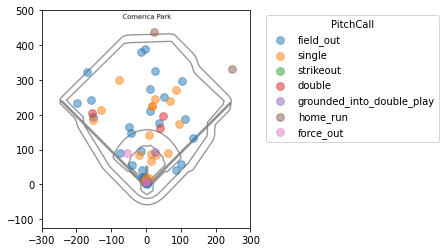

In [116]:
# code inspiration found from pybaseballs documentation: https://github.com/jldbc/pybaseball/blob/master/pybaseball/plotting.py
# only takes in data where ball is put inplay
def spray_chart(inplay_data,indiv_player):
    # pull stadium plot to overlay hits on
    stadium_img = mpimg.imread('tigers_stadium.png')

    fig, ax = plt.subplots()
    ax.imshow(stadium_img, extent=[-300, 300, -125, 500])  # Adjust extent to fit your data scale

    colorby = 'PitchCall'
    color_label = 'PitchCall'
    legend_title = 'PitchCall'
    size = 60
    
    scatters = []
    for color in inplay_data[color_label].unique():
        color_sub_data = inplay_data[inplay_data[color_label] == color]
        scatters.append(ax.scatter(
            color_sub_data["LandingPositionX"], color_sub_data['LandingPositionY'], size, label=color, alpha=0.5
        ))
        if(indiv_player):
            # Iterate over the rows of color_sub_data to annotate each point
            for _, row in color_sub_data.iterrows():
                ax.annotate(str(row['At_Bat_Num']),  # Convert 'at-bat' to string if it's not already
                            (row["LandingPositionX"], row['LandingPositionY'])
                            )
        
    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.draw()

    plt.show()

test = data[((data.PitchResult != 'Walk') & (data.PitchResult != 'Not In-Play'))]

spray_chart(test,0)

In [117]:
# Change name of 'grounded_into_double_play' call
data.PitchCall = data.PitchCall.apply(lambda x: 'GIDP' if x=='grounded_into_double_play' else x)

In [118]:
data.to_csv('data_new.csv',mode = 'w+')